In [3]:
import cv2
import matplotlib.pyplot as plt
import os
import random
import albumentations as A
import numpy as np

In [4]:
def read_img(img_path):
    return cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

def save_image(image, output_path = "generated_dataset/images"):
    cv2.imwrite(output_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

def display_image(image, title="Image"):
    """
    Display an image using matplotlib. Rembember to use plt.show() to display the image
    """
    plt.imshow(image)
    plt.title(title)
    plt.show()


plot bounding box để check

In [3]:
# đầu vào định dạng yolo
def plot_BB(image_path, coord_path):
    image = read_img(image_path)

    with open(coord_path, "r") as f:
        coordinates = [line.strip().split() for line in f.readlines()]

    plt.imshow(image)
    for coord in coordinates:
        # Split the coordinates
        label, x_cen, y_cen, w, h = map(float, coord)
        x = x_cen - w / 2
        y = y_cen - h / 2
        # Scale the coordinates to the image dimensions
        x *= image.shape[1]
        y *= image.shape[0]
        w *= image.shape[1]
        h *= image.shape[0]
        # Convert coordinates to integers
        x, y, w, h = map(int, (x, y, w, h))

        rect_box = plt.Rectangle((x, y), w, h, color='red', fill=False, lw=1)
        plt.gca().add_patch(rect_box)

    plt.show()

test đọc, display ảnh

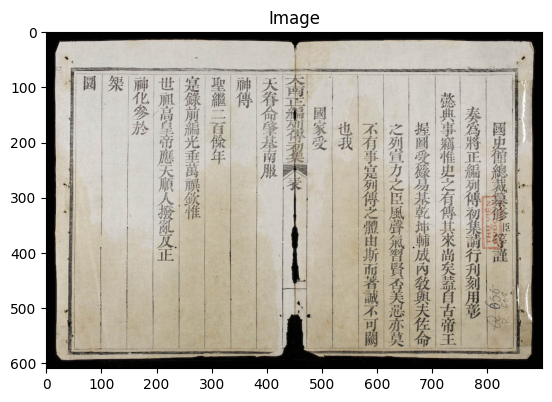

In [5]:
img_gt = "wb_localization_dataset/images/train/nlvnpf-0137-01-001.jpg"   #path to the groundtruth image
img = read_img(img_gt)
display_image(img)

sinh thêm dataset

Các kỹ thuật cơ bản

In [5]:
#SCALE
def scale_transform(image, bboxes):
    scale_x = round(random.uniform(0.5, 2), 1)  # Tỉ lệ ngẫu nhiên cho chiều rộng
    scale_y = round(random.uniform(0.5, 2), 1)  # Tỉ lệ ngẫu nhiên cho chiều cao

    # Định nghĩa phép biến đổi bounding box
    bbox_params = A.BboxParams(format='yolo')
    transform = A.Compose([
        A.Resize(height=int(image.shape[0] * scale_y), width=int(image.shape[1] * scale_x), p=1),
        #A.RandomScale(scale_limit=(0.5, 2), p=1),
    ], bbox_params=bbox_params)
    
    # Áp dụng phép biến đổi
    transformed = transform(image=image, bboxes=bboxes)

    # Sau khi augmentation
    transformed_img = transformed['image']
    transformed_bboxes = transformed['bboxes']
    
    return transformed_img, transformed_bboxes

#ROTATE
def rotate_transform(image, bboxes):
    # Định nghĩa phép biến đổi bounding box
    bbox_params = A.BboxParams(format='yolo')
    transform = A.Compose([
        A.Rotate(limit=15, p=1)
    ], bbox_params=bbox_params)
    
    # Áp dụng phép biến đổi
    transformed = transform(image=image, bboxes=bboxes)

    # Sau khi augmentation
    transformed_img = transformed['image']
    transformed_bboxes = transformed['bboxes']
    
    return transformed_img, transformed_bboxes

#ADD NOISE
def gaussian_noise_transform(image, bboxes):
    # Định nghĩa phép biến đổi bounding box
    bbox_params = A.BboxParams(format='yolo')
    transform = A.Compose([
        A.GaussNoise(p=1),
        #A.MultiplicativeNoise(multiplier=[0.5, 1.5], per_channel=True, elementwise=True, p=1),
    ], bbox_params=bbox_params)
    
    # Áp dụng phép biến đổi
    transformed = transform(image=image, bboxes=bboxes)

    # Sau khi augmentation
    transformed_img = transformed['image']
    transformed_bboxes = transformed['bboxes']
    
    return transformed_img, transformed_bboxes

def multiplicative_noise_transform(image, bboxes):
    # Định nghĩa phép biến đổi bounding box
    bbox_params = A.BboxParams(format='yolo')
    transform = A.Compose([
        #A.GaussNoise(p=1),
        A.MultiplicativeNoise(multiplier=[0.5, 1.5], per_channel=True, elementwise=True, p=1),
    ], bbox_params=bbox_params)
    
    # Áp dụng phép biến đổi
    transformed = transform(image=image, bboxes=bboxes)

    # Sau khi augmentation
    transformed_img = transformed['image']
    transformed_bboxes = transformed['bboxes']
    
    return transformed_img, transformed_bboxes

generate scaled data

In [6]:
def handle_scale(in_img_path, in_lb_path, out_img_path, out_lb_path):
    img = read_img(in_img_path)

    with open(in_lb_path, "r") as inf, open(out_lb_path, "w") as outf:
        bboxes = []
        for line in inf.readlines():
            values = line.strip().split()
            x_center, y_center, width, height = map(float, values[1:5])
            class_id = int(values[0])
            bboxes.append([x_center, y_center, width, height, class_id])
        agm_img, agm_bbox = scale_transform(img, bboxes)
        for bbox in agm_bbox:
            outf.write(f"{'0'} {bbox[0]:.6f} {bbox[1]:.6f} {bbox[2]:.6f} {bbox[3]:.6f}\n")
        save_image(agm_img, out_img_path)

def handle_scale_convert(images_folder, labels_folder):
    out_folder = "generated_dataset/scaled_data/scaled_original_data/"
    f_images = out_folder + "images/"
    f_labels = out_folder + "labels/"

    for fileImgName in os.listdir(images_folder):
        if fileImgName.endswith(".jpg"):  
            general_name = fileImgName.split('.')[0]
            out_img_name = f_images + "_scaled_" + fileImgName
            in_img_name = images_folder + "/" + fileImgName
            #print(in_img_name)
            #print(out_img_name)

            fileLbName = general_name + ".txt"
            out_label_name = f_labels + "_scaled_" + fileLbName
            in_label_name = labels_folder + "/" + fileLbName
            #print(in_label_name)

            handle_scale(in_img_name, in_label_name, out_img_name, out_label_name)

In [15]:
#handle_scale_convert("wb_localization_dataset/images/train", "wb_localization_dataset/labels/train")

generate rotated_data

generate offically

In [7]:
def handle_rotate(in_img_path, in_lb_path, out_img_path, out_lb_path):
    img = read_img(in_img_path)

    with open(in_lb_path, "r") as inf, open(out_lb_path, "w") as outf:
        bboxes = []
        for line in inf.readlines():
            values = line.strip().split()
            x_center, y_center, width, height = map(float, values[1:5])
            class_id = int(values[0])
            bboxes.append([x_center, y_center, width, height, class_id])
        agm_img, agm_bbox = rotate_transform(img, bboxes)
        for bbox in agm_bbox:
            outf.write(f"{'0'} {bbox[0]:.6f} {bbox[1]:.6f} {bbox[2]:.6f} {bbox[3]:.6f}\n")
        save_image(agm_img, out_img_path)

def handle_rotate_convert(images_folder, labels_folder):
    out_folder = "generated_dataset/rotated_data/rotated_original_data/"
    f_images = out_folder + "images/"
    f_labels = out_folder + "labels/"

    for fileImgName in os.listdir(images_folder):
        if fileImgName.endswith(".jpg"):  
            general_name = fileImgName.split('.')[0]
            out_img_name = f_images + "_rotated_" + fileImgName
            in_img_name = images_folder + "/" + fileImgName
            #print(in_img_name)
            #print(out_img_name)

            fileLbName = general_name + ".txt"
            out_label_name = f_labels + "_rotated_" + fileLbName
            in_label_name = labels_folder + "/" + fileLbName
            #print(in_label_name)

            handle_scale(in_img_name, in_label_name, out_img_name, out_label_name)

In [20]:
#handle_rotate_convert("wb_localization_dataset/images/train", "wb_localization_dataset/labels/train")

generate noised data

generate offically

In [8]:
def handle_gaussian_noise(in_img_path, in_lb_path, out_img_path, out_lb_path):
    img = read_img(in_img_path)

    with open(in_lb_path, "r") as inf, open(out_lb_path, "w") as outf:
        bboxes = []
        for line in inf.readlines():
            values = line.strip().split()
            x_center, y_center, width, height = map(float, values[1:5])
            class_id = int(values[0])
            bboxes.append([x_center, y_center, width, height, class_id])
        agm_img, agm_bbox = gaussian_noise_transform(img, bboxes)
        for bbox in agm_bbox:
            outf.write(f"{'0'} {bbox[0]:.6f} {bbox[1]:.6f} {bbox[2]:.6f} {bbox[3]:.6f}\n")
        save_image(agm_img, out_img_path)

def handle_multiplicative_noise(in_img_path, in_lb_path, out_img_path, out_lb_path):
    img = read_img(in_img_path)

    with open(in_lb_path, "r") as inf, open(out_lb_path, "w") as outf:
        bboxes = []
        for line in inf.readlines():
            values = line.strip().split()
            x_center, y_center, width, height = map(float, values[1:5])
            class_id = int(values[0])
            bboxes.append([x_center, y_center, width, height, class_id])
        agm_img, agm_bbox = multiplicative_noise_transform(img, bboxes)
        for bbox in agm_bbox:
            outf.write(f"{'0'} {bbox[0]:.6f} {bbox[1]:.6f} {bbox[2]:.6f} {bbox[3]:.6f}\n")
        save_image(agm_img, out_img_path)

def handle_gaussian_noise_convert(images_folder, labels_folder, out_folder):
    f_images = out_folder + "images/"
    f_labels = out_folder + "labels/"

    for fileImgName in os.listdir(images_folder):
        if fileImgName.endswith(".jpg"):  
            general_name = fileImgName.split('.')[0]
            out_img_name = f_images + "_gaussian_noise_" + fileImgName
            in_img_name = images_folder + "/" + fileImgName
            #print(in_img_name)
            #print(out_img_name)

            fileLbName = general_name + ".txt"
            out_label_name = f_labels + "_gaussian_noise_" + fileLbName
            in_label_name = labels_folder + "/" + fileLbName
            #print(in_label_name)

            handle_gaussian_noise(in_img_name, in_label_name, out_img_name, out_label_name)

def handle_multiplicative_noise_convert(images_folder, labels_folder, out_folder):
    f_images = out_folder + "images/"
    f_labels = out_folder + "labels/"

    for fileImgName in os.listdir(images_folder):
        if fileImgName.endswith(".jpg"):  
            general_name = fileImgName.split('.')[0]
            out_img_name = f_images + "_multiplicative_noise_" + fileImgName
            in_img_name = images_folder + "/" + fileImgName
            #print(in_img_name)
            #print(out_img_name)

            fileLbName = general_name + ".txt"
            out_label_name = f_labels + "_multiplicative_noise_" + fileLbName
            in_label_name = labels_folder + "/" + fileLbName
            #print(in_label_name)

            handle_multiplicative_noise(in_img_name, in_label_name, out_img_name, out_label_name)

In [25]:
out_folder = "generated_dataset/noised_data/noised_original_data/multiplicative_noised_data/"

#handle_multiplicative_noise_convert("wb_localization_dataset/images/train", "wb_localization_dataset/labels/train", out_folder)

combination generating

variant: rotate, flip, add noise, blur, bright

In [9]:
def multi_transform(image, bboxes):
    # Định nghĩa phép biến đổi bounding box
    bbox_params = A.BboxParams(format='yolo')

    scale_x = round(random.uniform(0.5, 2), 1)  # Tỉ lệ ngẫu nhiên cho chiều rộng
    scale_y = round(random.uniform(0.5, 2), 1)  # Tỉ lệ ngẫu nhiên cho chiều cao
    
    transform = A.Compose([
        A.RandomBrightnessContrast(brightness_limit=(-0.5, 0.5), contrast_limit=(-0.5,0.5), p=0.5),
        A.HorizontalFlip(p=0.5),
        A.Blur(blur_limit=3, p=0.5),
        A.GaussNoise(p=0.5),
        A.Rotate(limit=15, p=0.5),
        A.Resize(height=int(image.shape[0] * scale_y), width=int(image.shape[1] * scale_x), p=0.5),
        #A.MultiplicativeNoise(multiplier=[0.5, 1.5], per_channel=True, elementwise=True, p=0.5),
        #A.RandomSizedCrop(min_max_height=(5, 100), height=image.shape[0], width=image.shape[1]),
    ], bbox_params=bbox_params)
    
    # Áp dụng phép biến đổi
    transformed = transform(image=image, bboxes=bboxes)

    # Sau khi augmentation
    transformed_img = transformed['image']
    transformed_bboxes = transformed['bboxes']
    
    return transformed_img, transformed_bboxes

sinh variant dataset

In [10]:
def handle_multi(in_img_path, in_lb_path, out_img_path, out_lb_path):
    img = read_img(in_img_path)

    with open(in_lb_path, "r") as inf, open(out_lb_path, "w") as outf:
        bboxes = []
        for line in inf.readlines():
            values = line.strip().split()
            x_center, y_center, width, height = map(float, values[1:5])
            class_id = int(values[0])
            bboxes.append([x_center, y_center, width, height, class_id])
        agm_img, agm_bbox = multi_transform(img, bboxes)
        for bbox in agm_bbox:
            outf.write(f"{'0'} {bbox[0]:.6f} {bbox[1]:.6f} {bbox[2]:.6f} {bbox[3]:.6f}\n")
        save_image(agm_img, out_img_path)

def handle_multi_convert(images_folder, labels_folder, out_folder):
    f_images = out_folder + "images/"
    f_labels = out_folder + "labels/"

    for fileImgName in os.listdir(images_folder):
        if fileImgName.endswith(".jpg"):  
            general_name = fileImgName.split('.')[0]
            out_img_name = f_images + "_multi_" + fileImgName
            in_img_name = images_folder + "/" + fileImgName
            #print(out_img_name)

            fileLbName = general_name + ".txt"
            out_label_name = f_labels + "_multi_" + fileLbName
            in_label_name = labels_folder + "/" + fileLbName
            #print(out_label_name)

            handle_multi(in_img_name, in_label_name, out_img_name, out_label_name)

In [31]:
out_folder = "generated_dataset/combine_3_with_others_data/original_data/"
#handle_multi_convert("wb_localization_dataset/images/train", "wb_localization_dataset/labels/train", out_folder)

add noise, rotate, scale cho các ảnh mất cân bằng dựa vào data hùng phân tích

In [42]:
biased_35_path = "List_imgs_with_rate/rate_35.txt"
biased_3_path = "List_imgs_with_rate/rate_3.txt"
fd_img_path = "wb_localization_dataset/images/train/"
fd_lb_path = "wb_localization_dataset/labels/train/"
out_img_path_combine_35 = "generated_dataset/combine_3_with_others_data/biased_rate_0.35_data/images/"
out_lb_path_combiine_35 = "generated_dataset/combine_3_with_others_data/biased_rate_0.35_data/labels/"

out_img_path_scale_35 = "generated_dataset/scaled_data/biased_rate_0.35_data/images/"
out_lb_path_scale_35 = "generated_dataset/scaled_data/biased_rate_0.35_data/labels/"

out_img_path_rotate_35 = "generated_dataset/rotated_data/biased_rate_0.35_data/images/"
out_lb_path_rotate_35 = "generated_dataset/rotated_data/biased_rate_0.35_data/labels/"

out_img_path_g_noise_35 = "generated_dataset/noised_data/biased_rate_0.35_data/gaussian_noised_data/images/"
out_lb_path_g_noise_35 = "generated_dataset/noised_data/biased_rate_0.35_data/gaussian_noised_data/labels/"

out_img_path_m_noise_35 = "generated_dataset/noised_data/biased_rate_0.35_data/multiplicative_noised_data/images/"
out_lb_path_m_noise_35 = "generated_dataset/noised_data/biased_rate_0.35_data/multiplicative_noised_data/labels/"

out_img_path_combine_3 = "generated_dataset/combine_3_with_others_data/biased_rate_0.3_data/images/"
out_lb_path_combiine_3 = "generated_dataset/combine_3_with_others_data/biased_rate_0.3_data/labels/"

out_img_path_scale_3 = "generated_dataset/scaled_data/biased_rate_0.3_data/images/"
out_lb_path_scale_3 = "generated_dataset/scaled_data/biased_rate_0.3_data/labels/"

out_img_path_rotate_3 = "generated_dataset/rotated_data/biased_rate_0.3_data/images/"
out_lb_path_rotate_3 = "generated_dataset/rotated_data/biased_rate_0.3_data/labels/"

out_img_path_g_noise_3 = "generated_dataset/noised_data/biased_rate_0.3_data/gaussian_noised_data/images/"
out_lb_path_g_noise_3 = "generated_dataset/noised_data/biased_rate_0.3_data/gaussian_noised_data/labels/"

out_img_path_m_noise_3 = "generated_dataset/noised_data/biased_rate_0.3_data/multiplicative_noised_data/images/"
out_lb_path_m_noise_3 = "generated_dataset/noised_data/biased_rate_0.3_data/multiplicative_noised_data/labels/"

prfx_combine_35 = "_multi_0.35_"
prfx_combine_3 = "_multi_0.3_"

prfx_scale_35 = "_scale_0.35_"
prfx_scale_3 = "_scale_0.3_"

prfx_rotate_35 = "_rotate_0.35_"
prfx_rotate_3 = "_rotate_0.3_"

prfx_g_noise_35 = "_gaussian_noise_0.35_"
prfx_g_noise_3 = "_gaussian_noise_0.3_"

prfx_m_noise_35 = "_multiplicative_noise_0.35_"
prfx_m_noise_3 = "_multiplicative_noise_0.3_"

MULTI GEN

In [22]:
with open(biased_35_path, "r") as f:
    for line in f.readlines():
        name = line.split('.')[0]
        img_path = fd_img_path + name + ".jpg"
        lb_path = fd_lb_path + name + ".txt"
        o_img_path = out_img_path_combine_35 + prfx_combine_35 + name + ".jpg"
        o_lb_path = out_lb_path_combiine_35 + prfx_combine_35 + name + ".txt"
        #print(o_img_path)
        #handle_multi(img_path, lb_path, o_img_path, o_lb_path)

with open(biased_3_path, "r") as f:
    for line in f.readlines():
        name = line.split('.')[0]
        img_path = fd_img_path + name + ".jpg"
        lb_path = fd_lb_path + name + ".txt"
        o_img_path = out_img_path_combine_3 + prfx_combine_3 + name + ".jpg"
        o_lb_path = out_lb_path_combiine_3 + prfx_combine_3 + name + ".txt"
        #print(o_img_path)
        #handle_multi(img_path, lb_path, o_img_path, o_lb_path)

SCALE GEN

In [25]:
with open(biased_35_path, "r") as f:
    for line in f.readlines():
        name = line.split('.')[0]
        img_path = fd_img_path + name + ".jpg"
        lb_path = fd_lb_path + name + ".txt"
        o_img_path = out_img_path_scale_35 + prfx_scale_35 + name + ".jpg"
        o_lb_path = out_lb_path_scale_35 + prfx_scale_35 + name + ".txt"
        #print(o_img_path)
        #handle_scale(img_path, lb_path, o_img_path, o_lb_path)

with open(biased_3_path, "r") as f:
    for line in f.readlines():
        name = line.split('.')[0]
        img_path = fd_img_path + name + ".jpg"
        lb_path = fd_lb_path + name + ".txt"
        o_img_path = out_img_path_scale_3 + prfx_scale_3 + name + ".jpg"
        o_lb_path = out_lb_path_scale_3 + prfx_scale_3 + name + ".txt"
        #print(o_img_path)
        #handle_scale(img_path, lb_path, o_img_path, o_lb_path)

ROTATE GEN

In [27]:
with open(biased_35_path, "r") as f:
    for line in f.readlines():
        name = line.split('.')[0]
        img_path = fd_img_path + name + ".jpg"
        lb_path = fd_lb_path + name + ".txt"
        o_img_path = out_img_path_rotate_35 + prfx_rotate_35 + name + ".jpg"
        o_lb_path = out_lb_path_rotate_35 + prfx_rotate_35 + name + ".txt"
        #print(o_img_path)
        #handle_rotate(img_path, lb_path, o_img_path, o_lb_path)

with open(biased_3_path, "r") as f:
    for line in f.readlines():
        name = line.split('.')[0]
        img_path = fd_img_path + name + ".jpg"
        lb_path = fd_lb_path + name + ".txt"
        o_img_path = out_img_path_rotate_3 + prfx_rotate_3 + name + ".jpg"
        o_lb_path = out_lb_path_rotate_3 + prfx_rotate_3 + name + ".txt"
        #print(o_img_path)
        #handle_rotate(img_path, lb_path, o_img_path, o_lb_path)

NOISE GEN


In [39]:
with open(biased_35_path, "r") as f:
    for line in f.readlines():
        name = line.split('.')[0]
        img_path = fd_img_path + name + ".jpg"
        lb_path = fd_lb_path + name + ".txt"
        o_img_path = out_img_path_g_noise_35 + prfx_g_noise_35 + name + ".jpg"
        o_lb_path = out_lb_path_g_noise_35 + prfx_g_noise_35 + name + ".txt"
        #print(o_img_path)
        #handle_gaussian_noise(img_path, lb_path, o_img_path, o_lb_path)

with open(biased_3_path, "r") as f:
    for line in f.readlines():
        name = line.split('.')[0]
        img_path = fd_img_path + name + ".jpg"
        lb_path = fd_lb_path + name + ".txt"
        o_img_path = out_img_path_g_noise_3 + prfx_g_noise_3 + name + ".jpg"
        o_lb_path = out_lb_path_g_noise_3 + prfx_g_noise_3 + name + ".txt"
        #print(o_img_path)
        #handle_gaussian_noise(img_path, lb_path, o_img_path, o_lb_path)

In [43]:
with open(biased_35_path, "r") as f:
    for line in f.readlines():
        name = line.split('.')[0]
        img_path = fd_img_path + name + ".jpg"
        lb_path = fd_lb_path + name + ".txt"
        o_img_path = out_img_path_m_noise_35 + prfx_m_noise_35 + name + ".jpg"
        o_lb_path = out_lb_path_m_noise_35 + prfx_m_noise_35 + name + ".txt"
        #print(o_img_path)
        #handle_multiplicative_noise(img_path, lb_path, o_img_path, o_lb_path)

with open(biased_3_path, "r") as f:
    for line in f.readlines():
        name = line.split('.')[0]
        img_path = fd_img_path + name + ".jpg"
        lb_path = fd_lb_path + name + ".txt"
        o_img_path = out_img_path_m_noise_3 + prfx_m_noise_3 + name + ".jpg"
        o_lb_path = out_lb_path_m_noise_3 + prfx_m_noise_3 + name + ".txt"
        #print(o_img_path)
        #handle_multiplicative_noise(img_path, lb_path, o_img_path, o_lb_path)

Generate translated image

In [7]:
def translate_transform(image, bboxes):
    bbox_params = A.BboxParams(format='yolo')
    transform = A.Compose([
        A.ShiftScaleRotate(shift_limit_x=0.3, shift_limit_y=0, scale_limit=0, rotate_limit=0, 
                       border_mode=cv2.BORDER_CONSTANT, value=(0,0,0), p=1.0),
    ], bbox_params=bbox_params)
    
    # Áp dụng phép biến đổi
    transformed = transform(image=image, bboxes=bboxes)

    # Sau khi augmentation
    transformed_img = transformed['image']
    transformed_bboxes = transformed['bboxes']
    
    return transformed_img, transformed_bboxes

In [9]:
def handle_translated_convert(in_img_path, in_lb_path, out_img_path, out_lb_path):
    img = read_img(in_img_path)

    with open(in_lb_path, "r") as inf, open(out_lb_path, "w") as outf:
        bboxes = []
        for line in inf.readlines():
            values = line.strip().split()
            x_center, y_center, width, height = map(float, values[1:5])
            class_id = int(values[0])
            bboxes.append([x_center, y_center, width, height, class_id])
        agm_img, agm_bbox = translate_transform(img, bboxes)
        for bbox in agm_bbox:
            outf.write(f"{'0'} {bbox[0]:.6f} {bbox[1]:.6f} {bbox[2]:.6f} {bbox[3]:.6f}\n")
        save_image(agm_img, out_img_path)

In [12]:
biased_path = "List_imgs_with_rate/rate_35.txt"
fd_img_path = "wb_localization_dataset/images/train/"
fd_lb_path = "wb_localization_dataset/labels/train/"
out_img_path = "generated_dataset/translated_data/translated_biased_rate_0.35_data/images/"
out_lb_path = "generated_dataset/translated_data/translated_biased_rate_0.35_data/labels/"

with open(biased_path, "r") as f:
    for line in f.readlines():
        name = line.split('.')[0]
        img_path = fd_img_path + name + ".jpg"
        lb_path = fd_lb_path + name + ".txt"
        o_img_path = out_img_path + name + ".jpg"
        o_lb_path = out_lb_path + name + ".txt"
        handle_translated_convert(img_path, lb_path, o_img_path, o_lb_path)


In [ ]:
def gen(images_folder, labels_folder):
    out_folder = "generated_dataset/translated_data/translated_original_data/"
    f_images = out_folder + "images/"
    f_labels = out_folder + "labels/"

    for fileImgName in os.listdir(images_folder):
        if fileImgName.endswith(".jpg"):  
            general_name = fileImgName.split('.')[0]
            out_img_name = f_images + fileImgName
            in_img_name = images_folder + "/" + fileImgName
            #print(out_img_name)

            fileLbName = general_name + ".txt"
            out_label_name = f_labels + fileLbName
            in_label_name = labels_folder + "/" + fileLbName
            print(out_label_name)

            handle_translated_convert(in_img_name, in_label_name, out_img_name, out_label_name)

gen("wb_localization_dataset/images/train", "wb_localization_dataset/labels/train")

NOISE ADDING

In [6]:
def add_pepper_noise(image, amount=0.01):
    output = np.copy(image)
    num_pepper = np.ceil(amount * image.size)
    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
    output[coords[0], coords[1], :] = 0
    return output

def add_uniform_noise(image, low=0, high=50):
    uniform = np.random.uniform(low, high, image.shape).astype(np.float32)
    noisy = cv2.add(image.astype(np.float32), uniform)
    return np.clip(noisy, 0, 255).astype(np.uint8)

def add_periodic_noise(image, freq=30):
    noise = np.zeros_like(image, dtype=np.float32)
    rows, cols = image.shape[:2]
    for i in range(rows):
        for j in range(cols):
            noise[i, j] = 127 * (1 + np.sin(2 * np.pi * freq * i / rows))
    noisy = cv2.addWeighted(image.astype(np.float32), 0.5, noise.astype(np.float32), 0.5, 0)
    return np.clip(noisy, 0, 255).astype(np.uint8)

def uniform_noise_transform(image, bboxes):
    transformed = add_uniform_noise(image)
    
    return transformed, bboxes

def periodic_noise_transform(image, bboxes):
    transformed = add_periodic_noise(image)
    
    return transformed, bboxes

def pepper_noise_transform(image, bboxes):
    transformed = add_pepper_noise(image)
    
    return transformed, bboxes


In [7]:
def handle_uniform_noise(in_img_path, in_lb_path, out_img_path, out_lb_path):
    img = read_img(in_img_path)

    with open(in_lb_path, "r") as inf, open(out_lb_path, "w") as outf:
        bboxes = []
        for line in inf.readlines():
            values = line.strip().split()
            x_center, y_center, width, height = map(float, values[1:5])
            class_id = int(values[0])
            bboxes.append([x_center, y_center, width, height, class_id])
        agm_img, agm_bbox = uniform_noise_transform(img, bboxes)
        for bbox in agm_bbox:
            outf.write(f"{'0'} {bbox[0]:.6f} {bbox[1]:.6f} {bbox[2]:.6f} {bbox[3]:.6f}\n")
        save_image(agm_img, out_img_path)

def handle_uniform_noise_convert(images_folder, labels_folder, out_folder):
    f_images = out_folder + "images/"
    f_labels = out_folder + "labels/"

    for fileImgName in os.listdir(images_folder):
        if fileImgName.endswith(".jpg"):  
            general_name = fileImgName.split('.')[0]
            out_img_name = f_images + "_uniform_noise_" + fileImgName
            in_img_name = images_folder + "/" + fileImgName
            #print(in_img_name)
            #print(out_img_name)

            fileLbName = general_name + ".txt"
            out_label_name = f_labels + "_uniform_noise_" + fileLbName
            in_label_name = labels_folder + "/" + fileLbName
            #print(in_label_name)
            #print(out_label_name)

            handle_uniform_noise(in_img_name, in_label_name, out_img_name, out_label_name)

out_folder = "generated_dataset/noised_data/original_data/uniform_noised_data/"
handle_uniform_noise_convert("wb_localization_dataset/images/train", "wb_localization_dataset/labels/train", out_folder)

In [ ]:
def handle_pepper_noise(in_img_path, in_lb_path, out_img_path, out_lb_path):
    img = read_img(in_img_path)

    with open(in_lb_path, "r") as inf, open(out_lb_path, "w") as outf:
        bboxes = []
        for line in inf.readlines():
            values = line.strip().split()
            x_center, y_center, width, height = map(float, values[1:5])
            class_id = int(values[0])
            bboxes.append([x_center, y_center, width, height, class_id])
        agm_img, agm_bbox = pepper_noise_transform(img, bboxes)
        for bbox in agm_bbox:
            outf.write(f"{'0'} {bbox[0]:.6f} {bbox[1]:.6f} {bbox[2]:.6f} {bbox[3]:.6f}\n")
        save_image(agm_img, out_img_path)

def handle_pepper_noise_convert(images_folder, labels_folder, out_folder):
    f_images = out_folder + "images/"
    f_labels = out_folder + "labels/"

    for fileImgName in os.listdir(images_folder):
        if fileImgName.endswith(".jpg"):  
            general_name = fileImgName.split('.')[0]
            out_img_name = f_images + "_pepper_noise_" + fileImgName
            in_img_name = images_folder + "/" + fileImgName
            #print(in_img_name)
            #print(out_img_name)

            fileLbName = general_name + ".txt"
            out_label_name = f_labels + "_pepper_noise_" + fileLbName
            in_label_name = labels_folder + "/" + fileLbName
            #print(in_label_name)
            #print(out_label_name)

            handle_pepper_noise(in_img_name, in_label_name, out_img_name, out_label_name)

out_folder = "generated_dataset/noised_data/original_data/pepper_noised_data/"
#handle_pepper_noise_convert("wb_localization_dataset/images/train", "wb_localization_dataset/labels/train", out_folder)